# Acquiring Data


In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

 99% 147M/149M [00:05<00:00, 29.0MB/s]
100% 149M/149M [00:05<00:00, 26.9MB/s]


In [3]:
!unzip /content/brain-tumor-mri-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training

# Import

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from keras.layers import Input
from keras import layers
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import array_to_img

# Image Preprocessing

In [5]:
# declare train data and val data directory
train_dir = '/content/Training'
test_dir = '/content/Testing'

In [6]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(
                    rescale=1./255,
)

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # data train directory
        shuffle=True,
        target_size=(224, 224),  # image res 224x224 px
        batch_size=32,
        class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=(224, 224), # image res 256x256 px
        batch_size=40,
        class_mode='categorical',
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Show Images Example

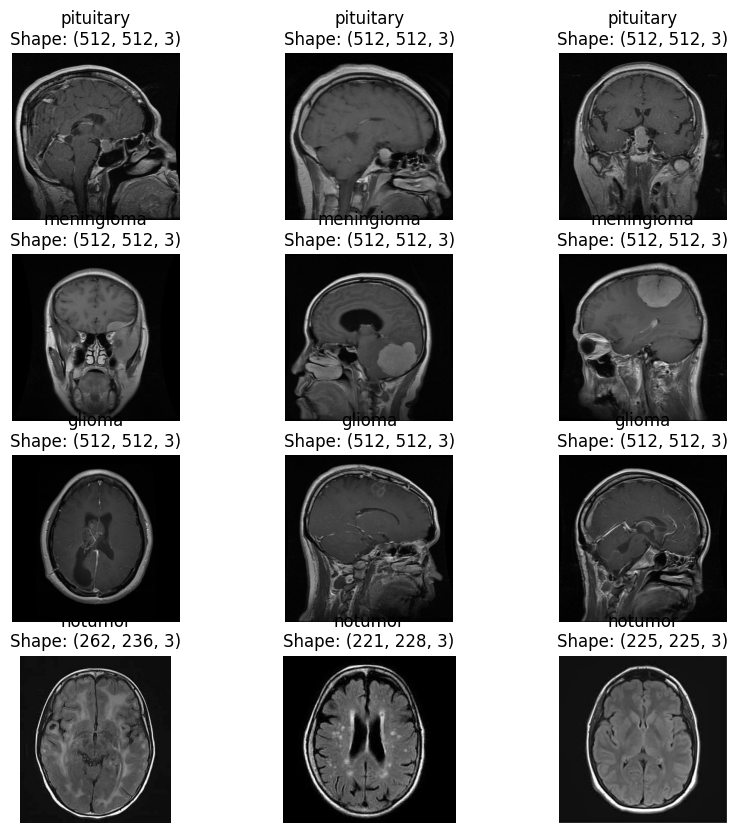

In [8]:
classes = os.listdir(train_dir)

n = 3

fig, axs = plt.subplots(len(classes), n, figsize=(10, 10))

for idx, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    img_class = os.listdir(class_path)

    for i in range(n):
        img_path = os.path.join(class_path, img_class[i])

        image = cv2.imread(img_path)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        shape = image.shape

        axs[idx, i].imshow(image_rgb)
        axs[idx, i].axis('off')
        axs[idx, i].set_title(f'{class_name}\nShape: {shape}')

plt.show()

# Transfer Learning with Densenet121

In [9]:
pre_trained_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

29084464/29084464 [==============================] - 2s 0us/step


## Fine Tuning

In [10]:
for layer in pre_trained_model.layers[:10]:
    layer.trainable = False

In [11]:
x = pre_trained_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [12]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [13]:
checkpointer = ModelCheckpoint(filepath='model/best_model_densenet121.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='max',
    min_lr=0.000001
)

# Training Model

In [14]:
history = model.fit(train_generator, epochs=7,
                    validation_data = test_generator,
                    batch_size=32,
                    callbacks=[checkpointer, reduce_lr])

Epoch 1/7
179/179 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.9060
Epoch 1: val_loss improved from inf to 0.36218, saving model to model/best_model_densenet121.h5
179/179 [==============================] - 165s 420ms/step - loss: 0.2961 - accuracy: 0.9060 - val_loss: 0.3622 - val_accuracy: 0.8574 - lr: 1.0000e-04
Epoch 2/7
179/179 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9830
Epoch 2: val_loss improved from 0.36218 to 0.06714, saving model to model/best_model_densenet121.h5
179/179 [==============================] - 66s 367ms/step - loss: 0.0453 - accuracy: 0.9830 - val_loss: 0.0671 - val_accuracy: 0.9764 - lr: 1.0000e-04
Epoch 3/7
179/179 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9937
Epoch 3: val_loss did not improve from 0.06714
179/179 [==============================] - 65s 363ms/step - loss: 0.0166 - accuracy: 0.9937 - val_loss: 0.0768 - val_accuracy: 0.9756 - lr: 1.0000e-04
Epoch 4/7
179/179 

# Model Evaluation

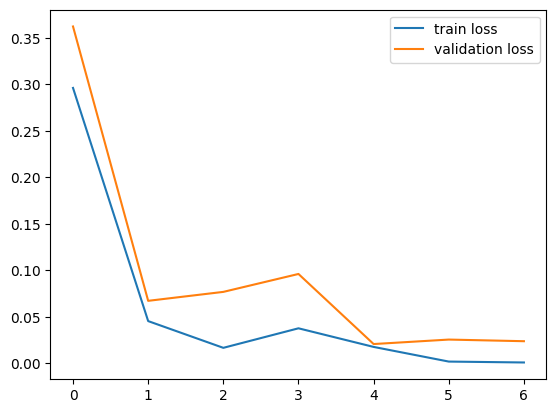

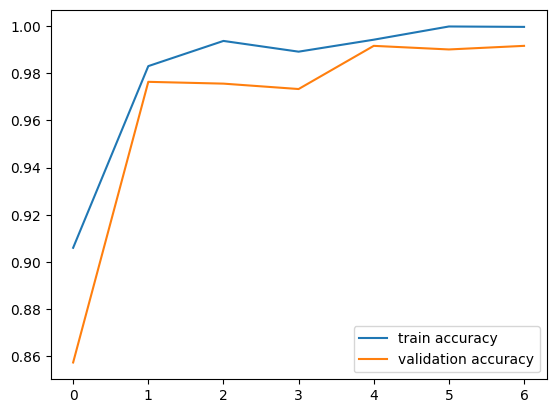

In [17]:
# plot report from model
def report_train(history):
    # loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.show()
    # accuracy
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.show()

report_train(history)

In [18]:
model.evaluate(test_generator,batch_size=16)
y_pred=model.predict(test_generator)
y_pred=np.argmax(y_pred,axis=1)
accuracy_score(y_pred,test_generator.classes)
print(classification_report(y_pred,test_generator.classes))

33/33 [==============================] - 4s 114ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       296
           1       0.99      0.98      0.98       309
           2       1.00      1.00      1.00       406
           3       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



## Show Misclassified Images


In [32]:
def visualize_misclassified_images(model, test_generator, class_indices):
    """
    Visualize misclassified images from the test set alongside their predicted and true labels.

    Parameters:
        model (tensorflow.keras.models.Model): The trained Keras model.
        test_generator (tensorflow.keras.preprocessing.image.DirectoryIterator): The test data generator.
        class_indices (dict): Dictionary mapping class names to their corresponding integer labels.

    Returns:
        None
    """

    misclassified_images = []
    misclassified_labels_true = []
    misclassified_labels_pred = []

    for i in range(len(test_generator)):
        batch_images, batch_labels = next(test_generator)
        batch_predictions = model.predict(batch_images, verbose=False)
        predicted_labels = [list(class_indices.keys())[np.argmax(pred)] for pred in batch_predictions]
        true_labels = [list(class_indices.keys())[np.argmax(label)] for label in batch_labels]

        for j in range(len(batch_images)):
            if predicted_labels[j] != true_labels[j]:
                misclassified_images.append(batch_images[j])
                misclassified_labels_true.append(true_labels[j])
                misclassified_labels_pred.append(predicted_labels[j])

    # Display misclassified images alongside their true and predicted labels
    num_misclassified = len(misclassified_images)
    num_rows = int(np.ceil(num_misclassified / 4))
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_misclassified):
        plt.subplot(num_rows, 4, i + 1)
        plt.title(f"True: {misclassified_labels_true[i]}\nPred: {misclassified_labels_pred[i]}", color='red')
        plt.imshow(array_to_img(misclassified_images[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

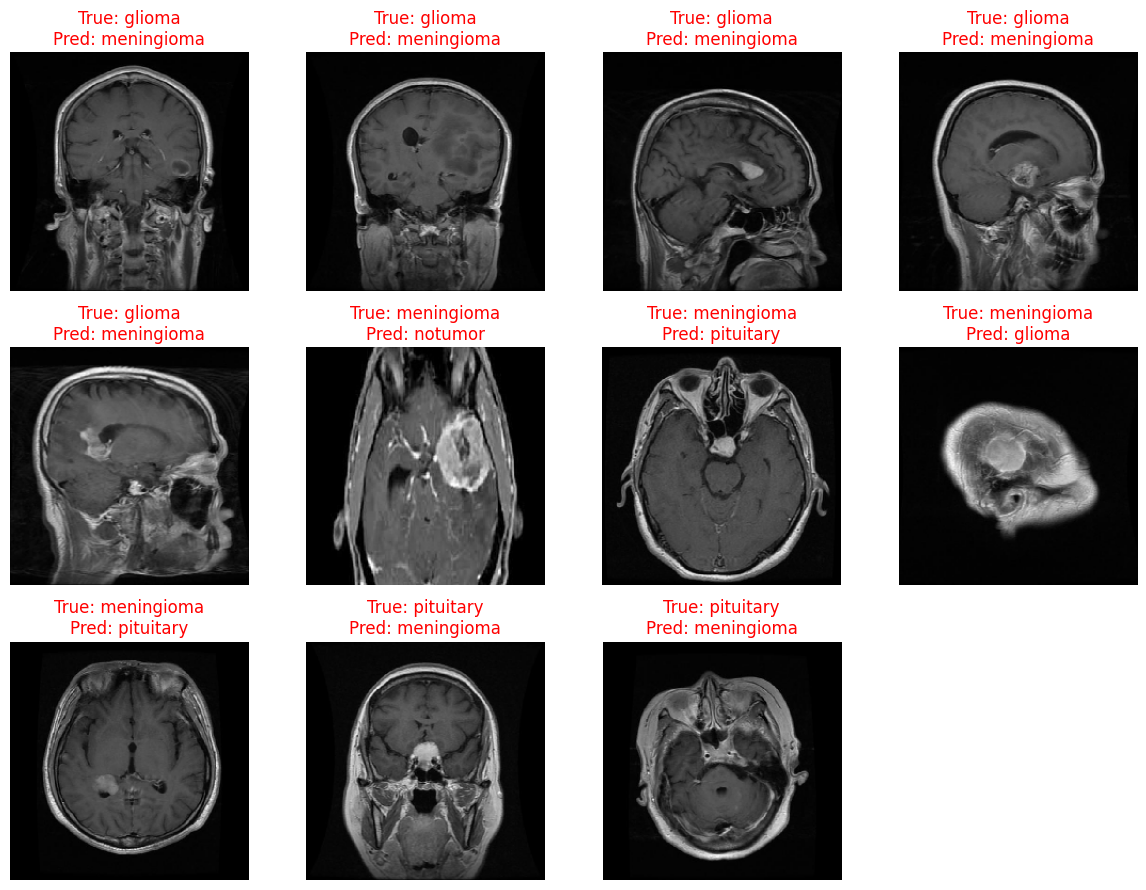

In [28]:
visualize_misclassified_images(model, test_generator, test_generator.class_indices)

out of a total of 1311 images tested, there were 11 images that were predicted incorrectly